In [1]:
import json
import collections
import random
import pandas as pd
import numpy as np
import os
import copy
import time
from sklearn.metrics import f1_score
from tqdm import tqdm,tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

import torch
from  transformers import  *
import torch.nn as nn
import torch.nn.functional as F

I0522 23:38:53.025776 16680 file_utils.py:39] PyTorch version 1.2.0 available.
I0522 23:38:53.066667 16680 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


# load data

In [2]:
train = pd.read_csv("data/train.csv",sep='\t')
test = pd.read_csv("data/test_new.csv",sep=',')
sample = pd.read_csv("data/sample.csv",sep=',')
test['label']=0
print(train.columns)
print(train.shape)
print(test.shape)
print(train.isnull().sum())
print(train.label.value_counts())

Index(['label', 'comment'], dtype='object')
(10000, 2)
(2000, 3)
label      0
comment    0
dtype: int64
0    8489
1    1511
Name: label, dtype: int64


# data detact

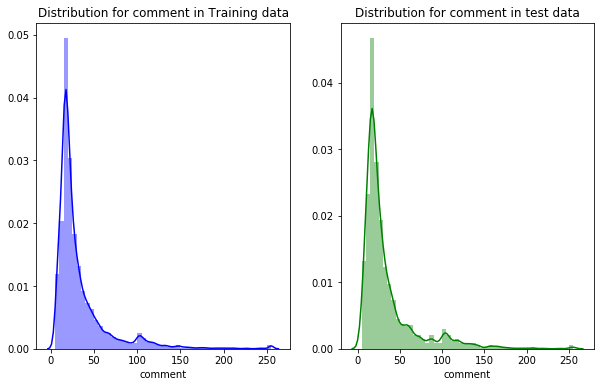

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#content length
train_data_content=train['comment'].str.len()
test_data_content=test['comment'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(train_data_content,ax=ax1,color='blue')
sns.distplot(test_data_content,ax=ax2,color='green')
ax2.set_title('Distribution for comment in test data')
ax1.set_title('Distribution for comment in Training data')
plt.show()

# config

In [4]:
MAX_LEN = 150
SEP_TOKEN_ID = 102
DEVICE = 'cuda'
Target_nums=['label']

SEED=2019
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


BERT_MODEL_PATH='E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/'

In [5]:
#create DataSet
class EmotionDataSet(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_PATH, cache_dir=None)
    
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        row = self.df.iloc[index]
        token_ids, seg_ids = self.get_token_ids(row)
        labels = self.get_label(row)
        return token_ids,seg_ids,labels
        
    def select_tokens(self, tokens, max_num):
        if len(tokens) <= max_num:
            return tokens
        else:
            return tokens[:max_num]
        
    def get_seg_ids(self, ids):
        seg_ids = torch.zeros_like(ids)
        seg_idx = 0
        for i, e in enumerate(ids):
            seg_ids[i] = seg_idx
            if e == SEP_TOKEN_ID:
                seg_idx += 1
        max_idx = torch.nonzero(seg_ids == seg_idx)
        seg_ids[max_idx] = 0
        return seg_ids

    def get_label(self, row):
        return torch.tensor(row[Target_nums].values.astype(np.float32))
    
    def get_token_ids(self,row):
        tokens= ['[CLS]'] + self.select_tokens(self.tokenizer.tokenize(row.comment),MAX_LEN-2)+['[SEP]']
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
    
        #padding
        if len(token_ids) < MAX_LEN:
            token_ids += [0] * (MAX_LEN- len(token_ids))
        #totensor
        ids = torch.tensor(token_ids)[:MAX_LEN]
        #segid
        seg_ids = self.get_seg_ids(ids)
        
        return ids,seg_ids

    def collate_fn(self, batch):
        token_ids = torch.stack([x[0] for x in batch])
        seg_ids = torch.stack([x[1] for x in batch])
        labels = torch.stack([x[2] for x in batch])
        return token_ids, seg_ids, labels.squeeze()
    

#DataLoader
def get_loader(df,batch_size=8,is_train=True):
    ds_df = EmotionDataSet(df)
    loader = torch.utils.data.DataLoader(ds_df, batch_size=batch_size, shuffle=is_train, num_workers=0, collate_fn=ds_df.collate_fn, drop_last=is_train)
    loader.num = len(ds_df)
    return loader

def test_train_loader(train):
    loader = get_loader(train,2)
    for token_ids, seg_ids,labels in loader:
        print(token_ids)
        print(seg_ids)
        print(labels)
        break
def test_test_loader(test):
    if Target_nums not in list(test.columns):
        test[Target_nums[0]]=0
    loader = get_loader(test,2)
    for token_ids, seg_ids,labels in loader:
        print(token_ids)
        print(seg_ids)
        break

In [6]:
test_train_loader(train)

I0522 23:38:53.674043 16680 tokenization_utils.py:306] Model name 'E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming 'E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/' is a path or url to a directory containing tokenizer files.
I0522 23:38:53.675040 16680 tokenization_utils.py:335] Didn't find file E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/added_tokens.json. We won't load it.
I0522 23:38:53.676038 16680 tokenization_utils.py:335] Didn't fi

tensor([[ 101, 1343,  749, 1962, 1914, 3613,  749,  511,  511,  511, 2600,  860,
         3341, 6432, 6820, 3221, 2523, 1962, 4638, 8024, 8024,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [7]:
test_test_loader(test)

I0522 23:38:53.719921 16680 tokenization_utils.py:306] Model name 'E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming 'E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/' is a path or url to a directory containing tokenizer files.
I0522 23:38:53.720918 16680 tokenization_utils.py:335] Didn't find file E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/added_tokens.json. We won't load it.
I0522 23:38:53.721915 16680 tokenization_utils.py:335] Didn't fi

tensor([[ 101, 2990, 1184, 5314, 2421, 1447, 6432, 1962,  749, 8024, 1168, 4157,
         1114, 3198, 1391, 7649, 8024, 1591,  800,  812, 2828, 5831, 6963, 1114,
         1906, 1962, 8024, 2769,  812,  738, 1114, 3198, 1168,  749, 8024, 5831,
          738,  677, 7970,  749, 8024, 1762, 3517,  677, 8024, 1282,  702,  782,
         8024, 5831, 4638,  819, 7030, 2523, 6639, 8024,  738, 2523, 1962, 1391,
         8013, 6631,  966, 8013,  809, 1400, 3300, 3322,  833,  671, 2137, 6820,
         3341, 8013,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

# bulid model

In [8]:
class EmotionModel(nn.Module):
    def __init__(self, n_classes=1):
        super(EmotionModel, self).__init__()
        self.model_name = 'EmotionModel'
        self.bert_model = BertModel.from_pretrained(BERT_MODEL_PATH,cache_dir=None)
        
        self.fcc= nn.Sequential(nn.Linear(768, n_classes))
        
    
    def forward(self,ids,seg_ids):
        attention_mask = (ids > 0)
        #last seq 是最后一层的输出
        last_seq,pooled_output=self.bert_model(input_ids=ids, attention_mask=attention_mask)
        out=self.fcc(last_seq[:,0,:]).sigmoid()
        return out
    

def test_model():
    x = torch.tensor([[1,2,3,4,5, 0, 0], [1,2,3,4,5, 0, 0]])
        
    seg_ids = torch.tensor([[1,0,0,0,0, 0, 0], [1,0,0,0,0, 0, 0]])
    model = EmotionModel()
    
    y = model(x, seg_ids)
    print(y)
netG = EmotionModel()
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))

I0522 23:38:53.768790 16680 configuration_utils.py:148] loading configuration file E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/config.json
I0522 23:38:53.769788 16680 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 21128
}

I0522 23:38:53.771782 16680 modeling_u

# generator parameters: 102268417


In [9]:
test_model()

I0522 23:38:55.278751 16680 configuration_utils.py:148] loading configuration file E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/config.json
I0522 23:38:55.280746 16680 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 21128
}

I0522 23:38:55.281743 16680 modeling_u

tensor([[0.6288],
        [0.6288]], grad_fn=<SigmoidBackward>)


In [10]:
logs='- epoch - {0:2d} - train_loss - {1:.4f} train_score - {2:.3f} - val_loss - {3:.4f} - val_score - {4:.3f} - best_loss - {5:.3f}'

#验证
def metric_fn(p, t):
    p=(p>0.5)*1
    return f1_score(t,p)


def validation_fn(model, loader, loss_fn):
    model.eval()
    y_pred, y_true, tloss = [], [], []
    for ids,seg_ids,target in loader:
        outputs = model(ids.cuda(DEVICE),seg_ids.cuda(DEVICE))
        loss = loss_fn(outputs.squeeze(), target.cuda(DEVICE))
        tloss.append(loss.item())
        y_true.append(target.detach().cpu().numpy())
        y_pred.append(outputs.detach().cpu().numpy())
        
    tloss = np.array(tloss).mean()
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    metric = metric_fn(y_pred, y_true)
    return tloss, metric

def predict_model_test(model,loader):
    model.eval()
    y_pred=[]
    for ids,seg_ids,_ in loader:
        outputs = model(ids.cuda(DEVICE),seg_ids.cuda(DEVICE))
        y_pred.append(outputs.detach().cpu().numpy())
    y_pred = np.concatenate(y_pred)
    return y_pred



def train_model(model,train_loader,val_loader,early_stop_epochs=2,accumulation_steps=2,epochs=4,model_save_path='pytorch_Emotion_model.pkl'):  
    
    
    no_improve_epochs=0
    
    ########优化器 学习率
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.8},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
            ]   
    
    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
    
    
    train_len=len(train_loader)
    
    #loss function
    loss_fn = nn.BCELoss().cuda(DEVICE)
    best_vmetric=1.
    
    
    logss=[]
    
    
    for epoch in range(1,epochs+1):
        
        y_pred, y_true = [], []
        start_time = time.time
        tloss = []
        model.train()
        bar = tqdm_notebook(train_loader)
        for i,(ids, seg_ids,labels) in enumerate(bar):
            outputs = model(ids.cuda(DEVICE),seg_ids.cuda(DEVICE))
#             print(labels)
            loss = loss_fn(outputs.squeeze(), labels.cuda(DEVICE))
            tloss.append(loss.item())
            loss.backward()
            #梯度累计
            if (i+1) % accumulation_steps == 0 or (i+1)==train_len:
                optimizer.step()
                optimizer.zero_grad()
            y_true.append(labels.detach().cpu().numpy())
            y_pred.append(outputs.detach().cpu().numpy())
            y_t = np.concatenate(y_pred)
            y_p = np.concatenate(y_true)
            metric = metric_fn(y_t,y_p)
            bar.set_postfix(loss=np.array(tloss).mean(),score=metric)
        
        tloss = np.array(tloss).mean()
        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)
        tmetric = metric_fn(y_pred, y_true)
        vloss, vmetric = validation_fn(model, val_loader, loss_fn)
        
        #test
        
        p=logs.format(epoch,tloss,tmetric,vloss,vmetric,best_vmetric)
        logss.append(p)
        print(p)
        
        
        
        #save best model
        if vloss<=best_vmetric:
            torch.save(model.state_dict(),model_save_path)
            best_vmetric=vloss
            no_improve_epochs=0
            print('improve save model!!!')
        else:
            no_improve_epochs+=1
        ###for eary stop
        if no_improve_epochs==early_stop_epochs:
            print('no improve score !!! stop train !!!')
            break
        
    return logss

In [11]:
FOLD=5
BATXH_SIZE=8
EPOCH=10
accumulation_steps=2
early_stop_epochs=2
netG = EmotionModel().cuda(DEVICE)


test_preds=test[['id']]
from sklearn.model_selection import KFold
kf = KFold(n_splits=FOLD, shuffle=True,random_state=2019)
test_loader=get_loader(test,BATXH_SIZE//2,False)
sum_preds=np.zeros((len(test),1))
for i,(train_index , test_index) in enumerate(kf.split(train,train)):
    
    print(i+1,'----------------------start')
    tra=train.iloc[train_index,:]
    val=train.iloc[test_index,:]
    
    print(tra.shape)
    print(val.shape)
    train_loader=get_loader(tra,BATXH_SIZE,True)
    val_loader=get_loader(val,BATXH_SIZE//2,False)
    
    model = EmotionModel().cuda(DEVICE)
    model_save_path='model_all_QA_{}.pkl'.format(i+1)
    logss=train_model(model,train_loader,val_loader,early_stop_epochs=early_stop_epochs,
                      accumulation_steps=accumulation_steps,epochs=EPOCH,
                      model_save_path=model_save_path)
    model.load_state_dict(torch.load(model_save_path))
    preds=predict_model_test(model,test_loader)
    test_preds.loc[:,'fold_label_{}'.format(i+1)]=(preds>0.5)*1
    sum_preds+=preds
    print(i+1,'-----------------------end')

I0522 23:38:56.884471 16680 configuration_utils.py:148] loading configuration file E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/config.json
I0522 23:38:56.886467 16680 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 21128
}

I0522 23:38:56.887464 16680 modeling_u

1 ----------------------start
(8000, 2)
(2000, 2)


I0522 23:39:01.005461 16680 tokenization_utils.py:306] Model name 'E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming 'E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/' is a path or url to a directory containing tokenizer files.
I0522 23:39:01.006459 16680 tokenization_utils.py:335] Didn't find file E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/added_tokens.json. We won't load it.
I0522 23:39:01.007456 16680 tokenization_utils.py:335] Didn't fi


- epoch -  1 - train_loss - 0.1025 train_score - 0.866 - val_loss - 0.1248 - val_score - 0.890 - best_loss - 1.000
improve save model!!!



- epoch -  2 - train_loss - 0.0507 train_score - 0.937 - val_loss - 0.0858 - val_score - 0.912 - best_loss - 0.125
improve save model!!!



- epoch -  3 - train_loss - 0.0299 train_score - 0.966 - val_loss - 0.1035 - val_score - 0.916 - best_loss - 0.086



- epoch -  4 - train_loss - 0.0149 train_score - 0.983 - val_loss - 0.1219 - val_score - 0.912 - best_loss - 0.086
no improve score !!! stop train !!!
1 -----------------------end
2 ----------------------start
(8000, 2)
(2000, 2)


I0522 23:58:32.044326 16680 tokenization_utils.py:306] Model name 'E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming 'E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/' is a path or url to a directory containing tokenizer files.
I0522 23:58:32.045322 16680 tokenization_utils.py:335] Didn't find file E:/code/pre_model/pytorch_bert/chinese_roberta_wwm_ext_pytorch/added_tokens.json. We won't load it.
I0522 23:58:32.045322 16680 tokenization_utils.py:335] Didn't fi

KeyboardInterrupt: 

In [12]:
for i in range(FOLD):
    sub_i=test_preds[['id','fold_label_{}'.format(i+1)]]
    sub_i.columns=['id','label']
    sub_i.to_csv('sub{}.csv'.format(i+1),index=False)
sum_preds/=FOLD
test_preds['label']=(sum_preds>0.5)*1
test_preds[['id','label']].to_csv('sub_mean',index=False)

KeyError: "['fold_label_2'] not in index"